<a href="https://colab.research.google.com/github/aleks-tu/XAI4CV-Projekt/blob/main/FeatureVisualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import torch
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt


def feature_visualization(model,
                          layer_key_path,
                          input_image_size = (224, 224),
                          learning_rate_gradient_ascent = 0.05,
                          steps_of_optimization = 100,
                          device = "cuda" if torch.cuda.is_available() else "cpu"):

    model = model.to(device).eval()
    model.requires_grad_(False)

    # Hook to access layer activations
    activations = None

    def hook_fn(module, input, output):
        nonlocal activations
        activations = output

    # Get layer and register forward hook
    layer = dict([*model.named_modules()])[layer_key_path]
    hook = layer.register_forward_hook(hook_fn)

    # Initialize input image as random noise
    input_tensor = torch.randn(1, 3, *input_image_size, device=device, requires_grad=True)
    optimizer = torch.optim.Adam([input_tensor], lr=learning_rate_gradient_ascent)

    for step in range(steps_of_optimization):
        optimizer.zero_grad()

        # Forward pass
        _ = model(input_tensor)

        # Compute feature maximization loss: L = -mean(activations)
        assert activations is not None, "No activations found, check your layer key!"
        loss = -activations.mean()

        # Backward pass
        loss.backward()
        optimizer.step()

        # Clamp the input to valid pixel range
        input_tensor.data.clamp_(-1.5, 1.5)  # Limiting the range to better focus

        if step % 50 == 0:
            print(f"Step [{step}/{steps_of_optimization}] - Loss: {loss.item()}")
        if step % 100 == 0: # Intermediate image visualization
            intermediate_img = input_tensor.detach().cpu().squeeze(0)
            #visualize_image(intermediate_img, f"Step [{step}/{steps_of_optimization}]", layer_key_path)

    hook.remove()

    result_img = input_tensor.detach().cpu().squeeze(0)
    return result_img

def visualize_image(img, step, layer_key_path):
  # Normalize image
  mean, std = torch.tensor([0.485, 0.456, 0.406]), torch.tensor([0.229, 0.224, 0.225])
  img = (img * std[:, None, None]) + mean[:, None, None]  # Denormalize
  img = torch.clamp(img, 0, 1)  # Clamp image values between 0 and 1

  plt.figure(figsize=(6, 6))
  plt.imshow(img.permute(1, 2, 0).numpy())
  plt.axis("off")
  plt.title(f"{step} - Feature visualization for {layer_key_path}")
  plt.show()

In [59]:
resnet50_model= models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

In [60]:
for name, module in resnet50_model.named_modules():
  print(name)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.conv2
layer1.0.bn2
layer1.0.conv3
layer1.0.bn3
layer1.0.relu
layer1.0.downsample
layer1.0.downsample.0
layer1.0.downsample.1
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.conv2
layer1.1.bn2
layer1.1.conv3
layer1.1.bn3
layer1.1.relu
layer1.2
layer1.2.conv1
layer1.2.bn1
layer1.2.conv2
layer1.2.bn2
layer1.2.conv3
layer1.2.bn3
layer1.2.relu
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.conv2
layer2.0.bn2
layer2.0.conv3
layer2.0.bn3
layer2.0.relu
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.conv2
layer2.1.bn2
layer2.1.conv3
layer2.1.bn3
layer2.1.relu
layer2.2
layer2.2.conv1
layer2.2.bn1
layer2.2.conv2
layer2.2.bn2
layer2.2.conv3
layer2.2.bn3
layer2.2.relu
layer2.3
layer2.3.conv1
layer2.3.bn1
layer2.3.conv2
layer2.3.bn2
layer2.3.conv3
layer2.3.bn3
layer2.3.relu
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.conv2
layer3.0.bn2
layer3.0.conv

Step [0/1000] - Loss: 10.261475563049316
Step [50/1000] - Loss: 3.7112762928009033
Step [100/1000] - Loss: 3.409656286239624
Step [150/1000] - Loss: 3.300191640853882
Step [200/1000] - Loss: 3.2258200645446777
Step [250/1000] - Loss: 3.177088975906372
Step [300/1000] - Loss: 3.1402032375335693
Step [350/1000] - Loss: 3.1092469692230225
Step [400/1000] - Loss: 3.0828185081481934
Step [450/1000] - Loss: 3.0602951049804688
Step [500/1000] - Loss: 3.044227361679077
Step [550/1000] - Loss: 3.0335922241210938
Step [600/1000] - Loss: 3.0255606174468994
Step [650/1000] - Loss: 3.018435001373291
Step [700/1000] - Loss: 3.011903762817383
Step [750/1000] - Loss: 3.0044121742248535
Step [800/1000] - Loss: 2.9995615482330322
Step [850/1000] - Loss: 2.995635986328125
Step [900/1000] - Loss: 2.9914357662200928
Step [950/1000] - Loss: 2.988956928253174


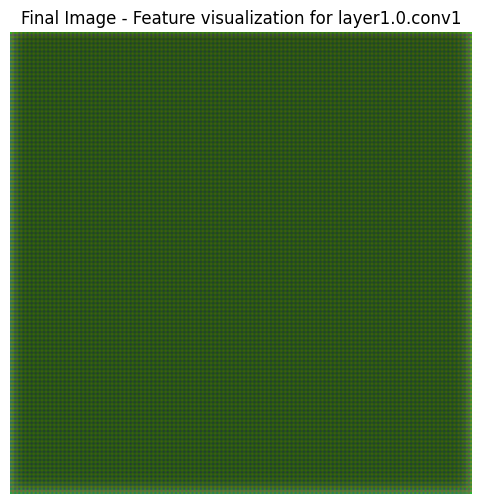

In [61]:
layer_key_path="layer1.0.conv1"
final_image = feature_visualization(resnet50_model, layer_key_path, steps_of_optimization=1000)
visualize_image(final_image, "Final Image", layer_key_path)

Step [0/1000] - Loss: 0.47844240069389343
Step [50/1000] - Loss: 0.21649298071861267
Step [100/1000] - Loss: 0.16518720984458923
Step [150/1000] - Loss: 0.1444346308708191
Step [200/1000] - Loss: 0.1368536800146103
Step [250/1000] - Loss: 0.13300730288028717
Step [300/1000] - Loss: 0.13067388534545898
Step [350/1000] - Loss: 0.12909381091594696
Step [400/1000] - Loss: 0.12793312966823578
Step [450/1000] - Loss: 0.12707068026065826
Step [500/1000] - Loss: 0.12641534209251404
Step [550/1000] - Loss: 0.12588462233543396
Step [600/1000] - Loss: 0.12545280158519745
Step [650/1000] - Loss: 0.12509529292583466
Step [700/1000] - Loss: 0.12480529397726059
Step [750/1000] - Loss: 0.12451398372650146
Step [800/1000] - Loss: 0.12425046414136887
Step [850/1000] - Loss: 0.12405414879322052
Step [900/1000] - Loss: 0.12385957688093185
Step [950/1000] - Loss: 0.12367921322584152


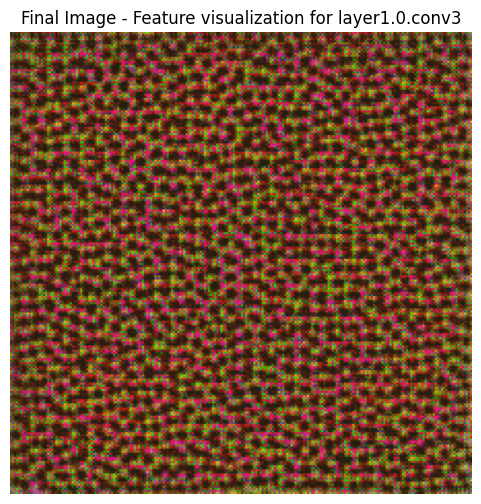

In [62]:
layer_key_path="layer1.0.conv3"
final_image = feature_visualization(resnet50_model, layer_key_path, steps_of_optimization=1000)
visualize_image(final_image, "Final Image", layer_key_path)

Step [0/1000] - Loss: 0.4546322226524353
Step [50/1000] - Loss: -0.5471540689468384
Step [100/1000] - Loss: -0.7035159468650818
Step [150/1000] - Loss: -0.77864670753479
Step [200/1000] - Loss: -0.8231697678565979
Step [250/1000] - Loss: -0.8531163334846497
Step [300/1000] - Loss: -0.8751622438430786
Step [350/1000] - Loss: -0.8923450112342834
Step [400/1000] - Loss: -0.9061456322669983
Step [450/1000] - Loss: -0.9175814986228943
Step [500/1000] - Loss: -0.9272972941398621
Step [550/1000] - Loss: -0.9355583786964417
Step [600/1000] - Loss: -0.9420985579490662
Step [650/1000] - Loss: -0.948104977607727
Step [700/1000] - Loss: -0.9535606503486633
Step [750/1000] - Loss: -0.9587092399597168
Step [800/1000] - Loss: -0.9632501006126404
Step [850/1000] - Loss: -0.9672247767448425
Step [900/1000] - Loss: -0.9711480736732483
Step [950/1000] - Loss: -0.974230170249939


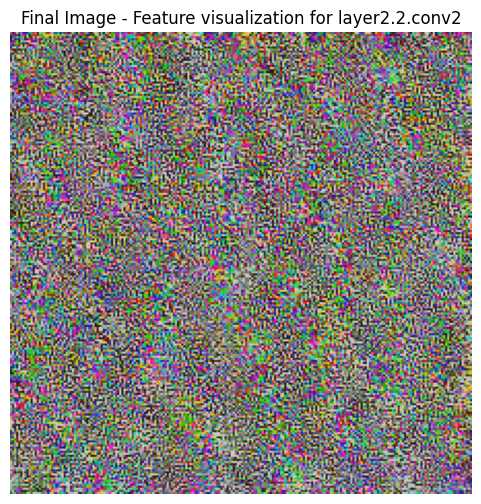

In [63]:
layer_key_path="layer2.2.conv2"
final_image = feature_visualization(resnet50_model, layer_key_path, steps_of_optimization=1000)
visualize_image(final_image, "Final Image", layer_key_path)

Step [0/1000] - Loss: 0.28929564356803894
Step [50/1000] - Loss: -0.1890103816986084
Step [100/1000] - Loss: -0.2624489367008209
Step [150/1000] - Loss: -0.3018818199634552
Step [200/1000] - Loss: -0.32895880937576294
Step [250/1000] - Loss: -0.34777310490608215
Step [300/1000] - Loss: -0.36352765560150146
Step [350/1000] - Loss: -0.37666040658950806
Step [400/1000] - Loss: -0.38755443692207336
Step [450/1000] - Loss: -0.39676299691200256
Step [500/1000] - Loss: -0.4044402539730072
Step [550/1000] - Loss: -0.41080379486083984
Step [600/1000] - Loss: -0.4177118241786957
Step [650/1000] - Loss: -0.42341145873069763
Step [700/1000] - Loss: -0.4273045063018799
Step [750/1000] - Loss: -0.43200457096099854
Step [800/1000] - Loss: -0.43653246760368347
Step [850/1000] - Loss: -0.4406948387622833
Step [900/1000] - Loss: -0.44401052594184875
Step [950/1000] - Loss: -0.4488758146762848


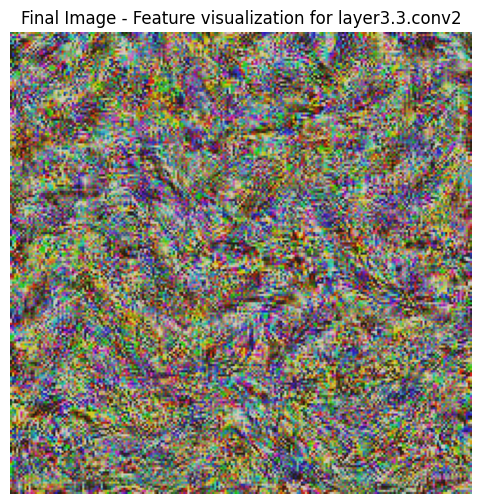

In [64]:
layer_key_path="layer3.3.conv2"
final_image = feature_visualization(resnet50_model, layer_key_path, steps_of_optimization=1000)
visualize_image(final_image, "Final Image", layer_key_path)

Step [0/1000] - Loss: 0.5998596549034119
Step [50/1000] - Loss: -0.288963258266449
Step [100/1000] - Loss: -0.43533962965011597
Step [150/1000] - Loss: -0.5291814208030701
Step [200/1000] - Loss: -0.6014957427978516
Step [250/1000] - Loss: -0.6657841801643372
Step [300/1000] - Loss: -0.7116746306419373
Step [350/1000] - Loss: -0.7677727341651917
Step [400/1000] - Loss: -0.8010655641555786
Step [450/1000] - Loss: -0.8497190475463867
Step [500/1000] - Loss: -0.8702422976493835
Step [550/1000] - Loss: -0.9073411226272583
Step [600/1000] - Loss: -0.9325279593467712
Step [650/1000] - Loss: -0.9621905088424683
Step [700/1000] - Loss: -0.9905076026916504
Step [750/1000] - Loss: -1.0165935754776
Step [800/1000] - Loss: -1.0366274118423462
Step [850/1000] - Loss: -1.0653774738311768
Step [900/1000] - Loss: -1.0803234577178955
Step [950/1000] - Loss: -1.1259912252426147


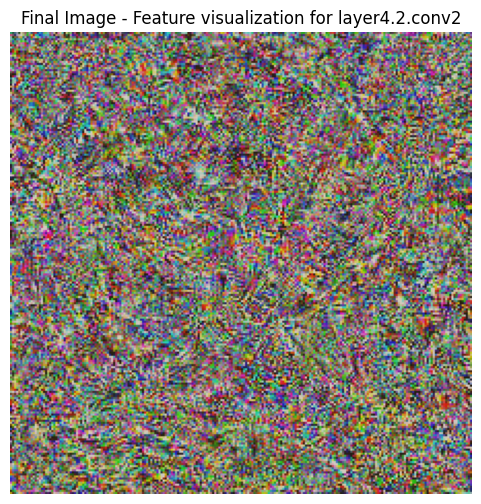

In [65]:
layer_key_path="layer4.2.conv2"
final_image = feature_visualization(resnet50_model, layer_key_path, steps_of_optimization=1000)
visualize_image(final_image, "Final Image", layer_key_path)